In [1]:
!pip install -q tensorflow tensorflow-datasets



In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


In [3]:
train_split = "train[:70%]"
val_split   = "train[70%:85%]"
test_split  = "train[85%:]"

ds_train = tfds.load("tf_flowers", split=train_split, as_supervised=True)
ds_val   = tfds.load("tf_flowers", split=val_split,   as_supervised=True)
ds_test  = tfds.load("tf_flowers", split=test_split,  as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.6WJ1PU_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [4]:
IMG_SIZE = 96
BATCH = 16

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32)
    image = preprocess_input(image)
    return image, label

ds_train = ds_train.map(preprocess).shuffle(2048).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_val   = ds_val.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(BATCH).prefetch(tf.data.AUTOTUNE)


In [5]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=5,      # quick training
                    callbacks=[es],
                    verbose=1)


Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 48s 163ms/step - accuracy: 0.6598 - loss: 0.8849 - val_accuracy: 0.8348 - val_loss: 0.4211
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9010 - loss: 0.2842 - val_accuracy: 0.8693 - val_loss: 0.3782
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9305 - loss: 0.1961 - val_accuracy: 0.8657 - val_loss: 0.3946
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9572 - loss: 0.1353 - val_accuracy: 0.8675 - val_loss: 0.4227


In [7]:
loss, acc = model.evaluate(ds_test, verbose=0)
print(f"✅ Test Accuracy: {acc:.4f} | Test Loss: {loss:.4f}")


✅ Test Accuracy: 0.8727 | Test Loss: 0.3479


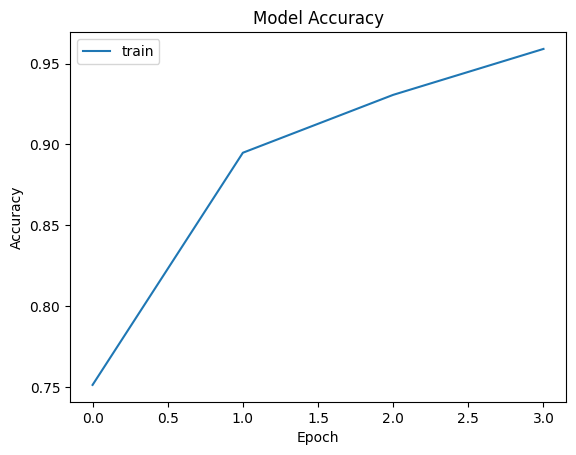

In [8]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


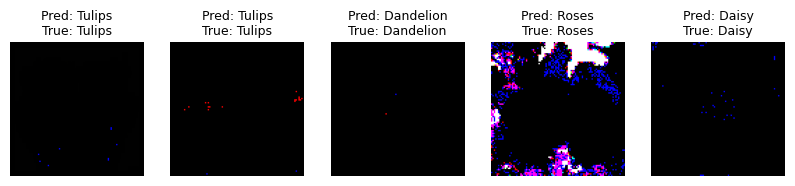

In [9]:
class_names = ['Dandelion', 'Daisy', 'Tulips', 'Sunflowers', 'Roses']

# Take 5 random test images
sample_images, sample_labels = [], []
for img, label in ds_test.unbatch().shuffle(100).take(5):
    sample_images.append(img)
    sample_labels.append(label.numpy())

sample_images = tf.stack(sample_images)
pred_probs = model.predict(sample_images)
pred_classes = np.argmax(pred_probs, axis=1)

# Display predictions
plt.figure(figsize=(10,5))
for i in range(len(sample_images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(tf.cast(sample_images[i], tf.uint8))
    plt.axis("off")
    plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[sample_labels[i]]}",
              fontsize=9)
plt.show()


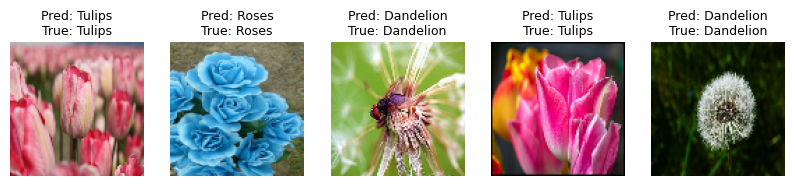

In [10]:
# load raw test once (no preprocessing)
raw_test = tfds.load("tf_flowers", split="train[85%:]", as_supervised=True)

display_imgs, model_imgs, sample_labels = [], [], []
for img, label in raw_test.shuffle(200).take(5):
    img_resized = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    display_imgs.append(tf.cast(img_resized, tf.uint8))                     # for plotting
    model_imgs.append(preprocess_input(tf.cast(img_resized, tf.float32)))   # for prediction
    sample_labels.append(label.numpy())

model_imgs = tf.stack(model_imgs)
pred_probs = model.predict(model_imgs, verbose=0)
pred_classes = np.argmax(pred_probs, axis=1)

plt.figure(figsize=(10,5))
for i in range(len(display_imgs)):
    plt.subplot(1, 5, i+1)
    plt.imshow(display_imgs[i])
    plt.axis("off")
    plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[sample_labels[i]]}",
              fontsize=9)
plt.show()
